In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tkinter as tk

stations = pd.read_csv("stations-chatgpt.csv")
routes = pd.read_csv("routes.csv")
lineColours = pd.read_csv("routeColours.csv")

In [8]:
stations.head()

,station,longitude,latitude
0,Pankow,13.411111,52.566667
1,Jannowitzbrücke,13.418389,52.514638
2,Bismarckstraße,13.304722,52.511389
3,Bernauer Straße,13.396722,52.537382
4,Gesundbrunnen,13.389444,52.548611


In [9]:
routes.head()

,von,nach,linie
0,Hauptbahnhof,Bundestag,U5
1,Bundestag,Brandenburger Tor,U5
2,Brandenburger Tor,Unter den Linden,U5
3,Unter den Linden,Museumsinsel,U5
4,Museumsinsel,Rotes Rathaus,U5


## Plot Berlin U- and S-Bahn network
This will include route colours and will related to latitude and longitude points
repeated stations in stations.csv will have to be removed

In [11]:
G = nx.Graph()
for i, node in stations.iterrows():
    G.add_node(node["station"], pos=(node["longitude"], node["latitude"]))

# removing missing stations
[G.remove_node(n) for n in G.nodes if n not in nx.get_node_attributes(G, "pos")]

for i, edge in routes.iterrows():
    G.add_edge(edge["von"], edge["nach"])

NetworkXError: Node 'Bundestag' has no position.

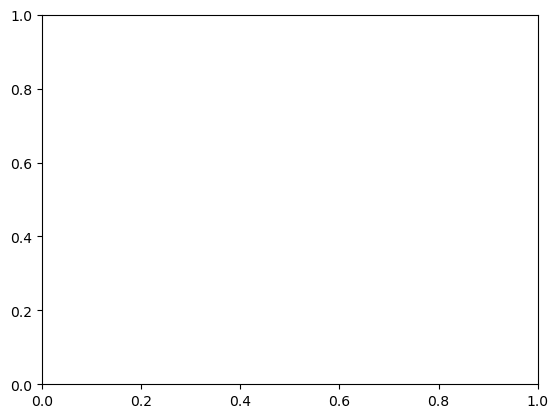

In [12]:
pos = nx.get_node_attributes(G, "pos")
nx.draw_networkx_nodes(G, pos, node_size=3, node_color="black", alpha=0.8)
#nx.draw_networkx_labels(G, pos, font_color="grey", font_weight="bold")
# perhaps draw each of the lines one by one depending on the route
nx.draw_networkx_edges(G, pos, edge_color="grey", width=0.5, arrows=False)

## Plot Berlin network against a map


In [ ]:
#https://cartopy.readthedocs.io/latest/matplotlib/feature_interface.html
mapProjection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1, projection=mapProjection)
ax.set_extent([12.9, 13.9, 52.3, 52.7], crs=ccrs.PlateCarree())

# plot geographical features
ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
ax.add_feature(cfeature.BORDERS, edgecolor="grey")
ax.add_feature(cfeature.LAKES, edgecolor="lightblue")
ax.add_feature(cfeature.OCEAN, edgecolor="lightblue")
ax.add_feature(cfeature.LAND, edgecolor="lightgreen")
ax.add_feature(cfeature.RIVERS, edgecolor="lightblue")
ax.add_feature(cfeature.STATES, edgecolor="grey")

# plot stations
ax.scatter(x=stations.longitude, y=stations.latitude, color="red", s=3, alpha=1, zorder=3,transform=ccrs.PlateCarree())

# plot connections
for u, v in G.edges():
    lon1, lat1 = pos[u]
    lon2, lat2 = pos[v]

    ax.plot([lon1, lon2], [lat1, lat2], color="grey", linewidth=0.5, alpha=0.5, transform=ccrs.Geodetic(), zorder=2)

## Historical maps
Import data stating which lines exists for each year from 1902 to today
{1902:[blah blah], 1903:[blah, blah]} or perhaps every connection could have the year it was added in case some lines were built over several years
use tkinter to create slider showing berlin ubahn lines throughout time
make to show border between east andd west
https://en.wikipedia.org/wiki/File:Berlin_transit_icons_-_U1.svg
https://python-course.eu/tkinter/sliders-in-tkinter.php
https://realpython.com/python-gui-tkinter/

## Real-time data
Add toggle in tkinter to switch to present day
When present day give option to show real time ubahn data about strikes and delays

## Add strassenbahn